# CDL Technical Assignment (TASK 2)

## BoSeong Kim
Bachelor Student @ Yonsei University

Contact boseong14@gmail.com

Lastly updated at May.24 2021 (UTC+9)

## Solving a simple max-cut problem using QAOA

### Abstract

A simple max-cut problem is a well-known NP-Complete problem. NP-Complete problems are considered unsolvable even if we have a complete fault-tolerant quantum computer. That is, it is almost impossible to get the exact solution. However, in most cases, we do not have to find the best. If an adequately optimized solution is sufficient, we can get such a solution much faster.

>The Quantum approximate optimization algorithm (QAOA) by Farhi, Goldstone and Gutmann is an example of a heuristic algorithm. Unlike Goemans-Williamson algorithm, QAOA does not come with performance guarantees.
>QAOA takes the approach of classical approximate algorithms and looks for a quantum analog that will likewise produce a classical bit string $x^*$ that with high probability is expected to have a good approximation ratio $\alpha$.

I followed the qiskit textbook ___Solving combinatorial optimization problems using QAOA___ replacing some of the codes to simulate the max-cut problem of 12 nodes. Since evaluating the expectation value of the given Hamiltonian classically requires a large-size symbolic computation, I fixed a specific graph by networkx gnp_random_graph function with a seed 137. Then I counted the neighboring edges of each $e \in E$. I considered that if the number of neighboring edges connected to each node forms the same tuple, it can be calculated that the expectation value of such $e$s are identical. Then I evaluated the function giving expectation value of such edges using Mathematica. Finally, using the $\gamma$ and $\beta$ I found, I could prepare the approximated state vector $\psi_{1}(\gamma, \beta)$. It was straightforward to measure the prepared state and evaluating the data from the outcome.

In [ ]:
!pip install qiskit ipywidgets

In [1]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

V = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
|E| = 28


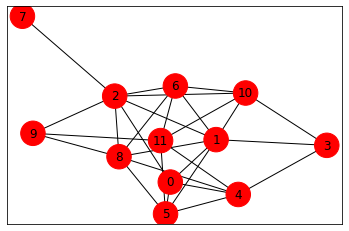

In [2]:
# Generating a graph with 12 nodes, probability p=1/2 for edges generation
n = 12
p = 1/2
seed = 137
# V = np.arange(0,n,1)
# E =[(0,1),(0,2),(1,2),(3,2),(3,4),(4,2)]

# Erdős-Rényi graph generator with seed 137
G = nx.gnp_random_graph(n, p, seed=137)
V = G.nodes
E = G.edges
# G.add_nodes_from(V)
# G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)
# print(f"V = {V}")
# print(f"|E| = {len(E)}")

### Counting neighboring edges

For each $i \in V$, 
ebn_counts counts the edges by nodes, i.e.
$$ \mathrm{ebn\_counts} = \mathrm{neighboring\:edges\:of\:}i $$

And then for each $j = (j_0, j_1) \in E$, 
nebe_counts counts the neighboring edges by edges, i.e.
$$ \mathrm{nebe\_counts} = (\mathrm{ebn\_counts}[j_0], \mathrm{ebn\_counts}[j_1]) $$

Finally, we assume that if the tuple $\mathrm{nebe\_counts}[k] = \mathrm{nebe\_counts}[k']$ including the reordering of the tuple, the expectation values are the same.
$$ f_{k}(\gamma, \beta) = f_{k'}(\gamma, \beta) $$

Then we get the list of unique neighboring edges and their counts.
There are $ \mathrm{unev\_counts[i]} = c_{i} $ edges that has neighboring $ \mathrm{un\_unique[i]} = \mathbf{n_i} = (n_0, n_1) $ neighboring edges. Then
$$ \left< \psi_{1}(\gamma, \beta) \right| H \left| \psi_{1}(\gamma, \beta) \right> = \displaystyle\sum\limits_{i} c_{i} \cdot f_{\mathbf{n}_i}(\gamma, \beta)$$

In [3]:
# count edges by nodes
# ebn_counts[i] denotes the number of edges at ith node
ebn_counts = np.zeros(n, dtype=int)
for i in G:
    ebn_counts[i] = len(G.edges(i))

# count neighboring edges by edges
# nebe_counts[k] denotes the neighboring edges of kth edge
nebe_counts = np.zeros((int(ebn_counts.sum()/2), 2), dtype=int)
k = 0
for i in G:
    for j in list(G.edges(i)):
        if i<j[1]:
            # since ebn includes the edge j twice, we subtract 1
            nebe_counts[k] = np.array([ebn_counts[i], ebn_counts[j[1]]])
            k += 1
            # print(f"{i}, {j[1]}, {ebn_counts[i]}, {ebn_counts[j[1]]}")

# list unique neighboring edges and their counts
ne_unique, unev_counts = np.unique(nebe_counts, return_counts=True, axis=0)
# print(f"Is unev_counts correct = {unev_counts.sum()==len(E)}")
# print(nebe_counts)
# print(ne_unique)
# print(unev_counts)

Is unev_counts correct = True


The functions
$$ f_{\mathbf{n}_i}(\gamma,\beta) =  \langle \psi_1(\gamma,\beta)|\;\frac{1}{2}\left(1 - Z_{n_0} Z_{n_1}\right)\;|\psi_1(\gamma,\beta)\rangle $$
are calculated by Mathematica

In [4]:
# Define f_i
def f_0(gamma, beta):
    return (1/2)*(1 + (1/8) * (np.cos(gamma)**2) * (np.sin(4*beta) * (5*np.sin(gamma)+np.sin(3*gamma))
                                                    + 8*(np.cos(4*beta)-1)*(np.sin(gamma)**2)*(np.cos(gamma)**2)))
def f_1(gamma, beta):
    return (1/2)*(1 - (1/8) * (2*(np.sin(2*beta)**2)*(np.sin(gamma)**2)*(8*np.cos(gamma)+3*np.cos(3*gamma)+np.cos(5*gamma))
                              - 2*np.sin(4*beta)*np.sin(gamma/2)*((np.cos(gamma/2)+np.cos(3*gamma/2))**3)))
def f_2(gamma, beta):
    return (1/2)*(1 - (1/16) * (8*(np.sin(2*beta)**2)*(np.sin(gamma)**2)*(np.cos(gamma)**3)
                                *(2*np.cos(2*gamma)+np.cos(4*gamma)+3)-np.sin(4*beta)
                                *(8*np.sin(gamma/2)-3*np.sin(3*gamma/2)+np.sin(5*gamma/2))
                                *((np.cos(gamma/2)+np.cos(3*gamma/2))**3)))
def f_3(gamma, beta):
    return (1/2)*(1 - (1/4) * (np.sin(2*beta)**2) * (np.sin(2*gamma)**2) * (np.cos(4*gamma)+3)
                 + np.sin(4*beta) * np.sin(gamma) * (np.cos(gamma)**4))
def f_4(gamma, beta):
    return (1/2)*(1 + (1/2) * np.cos(gamma**3) * (np.sin(4*beta)*np.sin(2*gamma)*(np.cos(gamma/2)**2)
                                                  + (np.cos(4*beta)-1)*(np.sin(gamma)**2)*(np.cos(4*gamma)+3)))
def f_5(gamma, beta):
    return (1/2)*(1 - (2*(np.sin(2*beta)**2)*(np.sin(gamma)**2)*(np.cos(gamma)**5) - np.sin(4*beta)*np.sin(gamma/2)
                      * (np.cos(gamma/2)**3)*(np.cos(gamma)**2)*(-2*np.cos(gamma)+np.cos(2*gamma)+3)))
def f_6(gamma, beta):
    return (1/2)*(1 + (1/128) * np.sin(4*beta) * (69*np.sin(gamma)+9*np.sin(3*gamma)+5*np.sin(5*gamma)+np.sin(7*gamma)))
def f_7(gamma, beta):
    return (1/2)*(1 - (2*(np.sin(2*beta)**2)*(np.sin(gamma)**2)*(np.cos(gamma)**6) - (1/32)*np.sin(4*beta)
                      * (18*np.sin(gamma)+3*np.sin(3*gamma)+np.sin(5*gamma))*(np.cos(gamma)**2)))
def f_8(gamma, beta):
    return (1/2)*(1 - (1/8) * np.cos(gamma**4) * (8*(np.sin(2*beta)**2)*(np.sin(gamma)**2)*(np.cos(4*gamma)+3)
                                                 - np.sin(4*beta)*(5*np.sin(gamma)+np.sin(3*gamma))))
def f_9(gamma, beta):
    return (1/2)*(1 - (1/16) * (np.sin(gamma)**2) * ((np.sin(2*beta)**2)*(44*np.cos(gamma)+22*np.cos(3*gamma)
                                                                         + 10*np.cos(5*gamma)+3*np.cos(7*gamma)
                                                                         + np.cos(9*gamma)) - 8*np.sin(4*beta)
                                                    *(np.cos(gamma)**5)*(np.cos(gamma/2)/np.sin(gamma/2))))
def f_10(gamma, beta):
    return (1/2)*(1 - ((1/16)*(np.sin(2*beta)**2)*(np.sin(2*gamma)**2)*(8*np.cos(4*gamma)+np.cos(8*gamma)+15)
                      - np.sin(4*beta)*np.sin(gamma)*(np.cos(gamma)**6)))

<ipython-input-5-c49895c8bde9>:31: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax  = fig.gca(projection='3d')


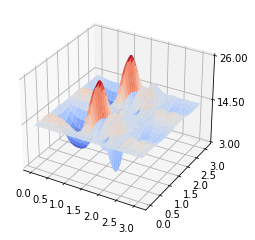


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 25.431
This is attained for gamma = 2.400 and beta = 1.400


In [5]:
# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma[0]      = 0.0000001
a_beta[0]       = 0.0000001
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = (unev_counts[0]*f_0(a_gamma, a_beta)
      + unev_counts[1]*f_1(a_gamma, a_beta)
      + unev_counts[2]*f_2(a_gamma, a_beta)
      + unev_counts[3]*f_3(a_gamma, a_beta)
      + unev_counts[4]*f_4(a_gamma, a_beta)
      + unev_counts[5]*f_5(a_gamma, a_beta)
      + unev_counts[6]*f_6(a_gamma, a_beta)
      + unev_counts[7]*f_7(a_gamma, a_beta)
      + unev_counts[8]*f_8(a_gamma, a_beta)
      + unev_counts[9]*f_9(a_gamma, a_beta)
      + unev_counts[10]*f_10(a_gamma, a_beta))

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(3,26)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

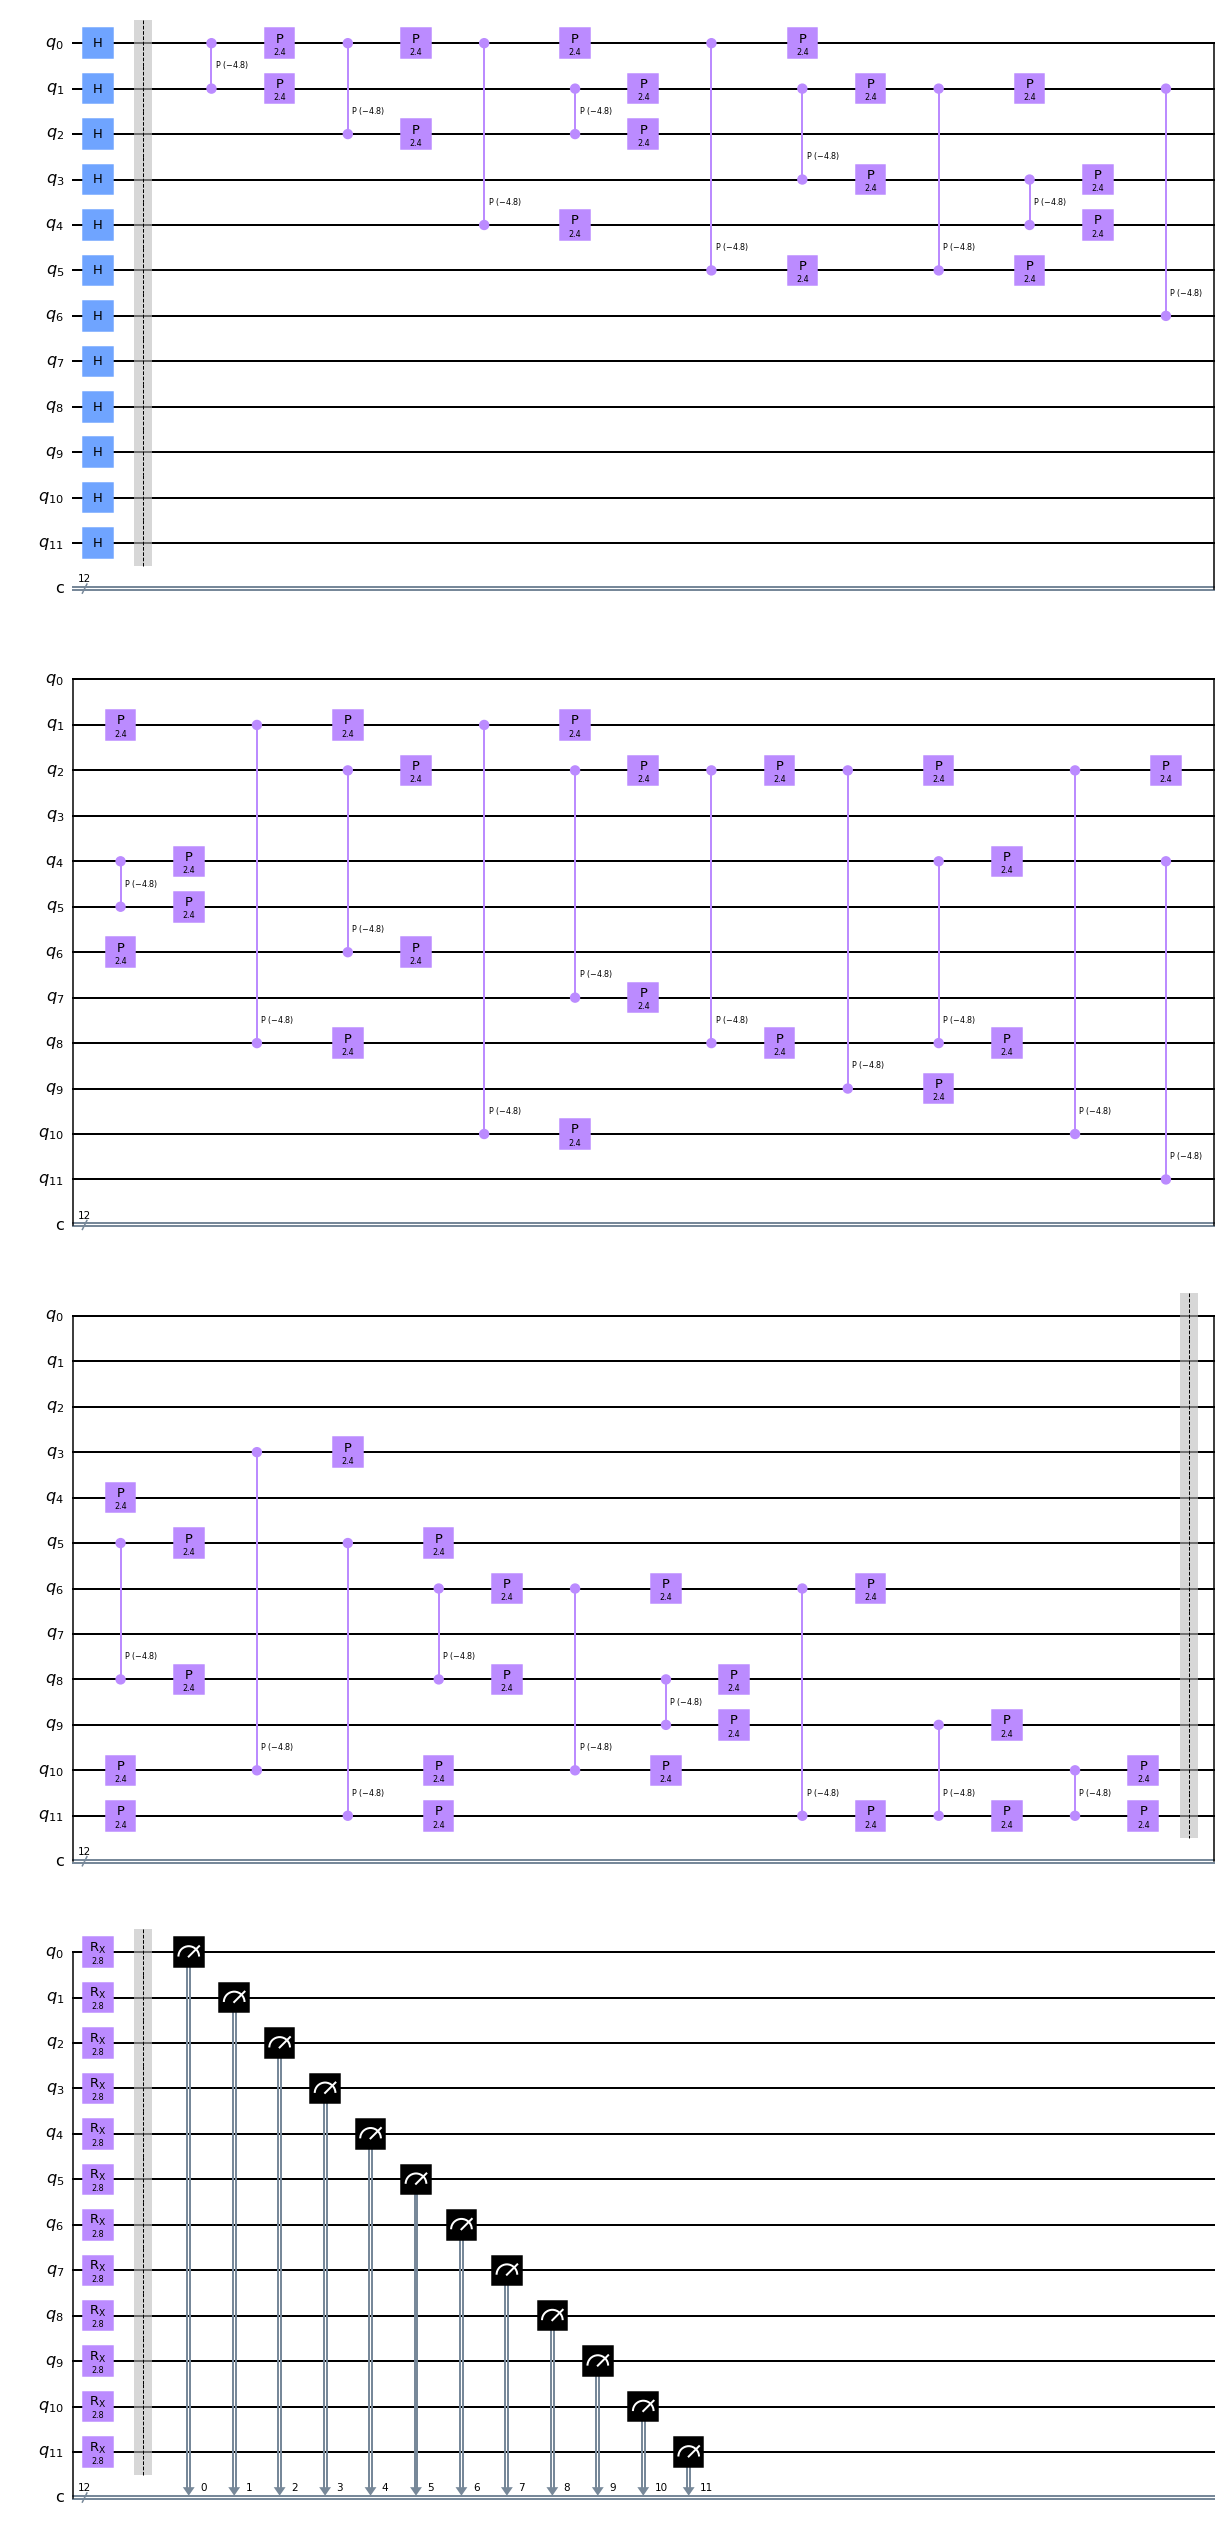

In [6]:
# prepare the quantum and classical resisters
QAOA = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
QAOA.h(range(len(V)))
QAOA.barrier()

# apply the Ising type gates with angle gamma along the edges in E
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cp(-2*gamma, k, l)
    QAOA.p(gamma, k)
    QAOA.p(gamma, l)
    
# then apply the single qubit X rotations with angle beta to all qubits
QAOA.barrier()
QAOA.rx(2*beta, range(len(V)))

# Finally measure the result in the computational basis
QAOA.barrier()
QAOA.measure(range(len(V)),range(len(V)))

### draw the circuit for comparison
QAOA.draw()

In [7]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        C = C + x[e1]*(1-x[e2]) + x[e2]*(1-x[e1])
        
    return C

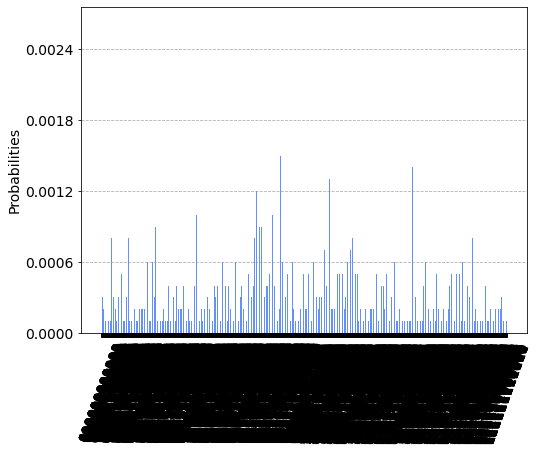

In [8]:
# run on local simulator
backend = Aer.get_backend("qasm_simulator")
shots = 10000

TQAOA = transpile(QAOA, backend)
qobj = assemble(TQAOA, shots=shots)
QAOA_results = backend.run(qobj).result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 14.42 while the true value is M1 = 25.43 

The approximate solution is x* = 010011110110 with C(x*) = 21 

The cost function is distributed as: 



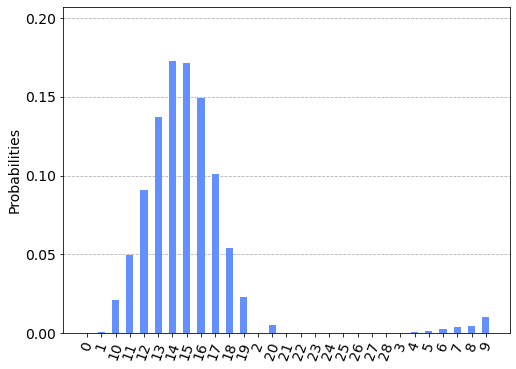

In [9]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

### Result of the simulation by qasm_simulator
It resulted {010011110110} and the optimized value is 21

In [11]:
# Use the IBMQ essex device
IBMQ.save_account('08952555d263c29c9b015855d49bcbf0e7a3cb1354b5520743285bb48d19f0db420522be05c80dd1fb19179c42d798b238ae7b944568bb6e7e7284d9bfeb0209')
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_16_melbourne')
shots = 2048

TQAOA = transpile(QAOA, backend)
qobj = assemble(TQAOA, shots=shots)
job_exp = backend.run(qobj)
job_monitor(job_exp)

ibmqfactory.load_account:WARNING:2021-05-24 01:51:33,290: Credentials are already in use. The existing account in the session will be replaced.
<ipython-input-11-794419ef9b18>:8: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job_exp = backend.run(qobj)


Job Status: job has successfully run


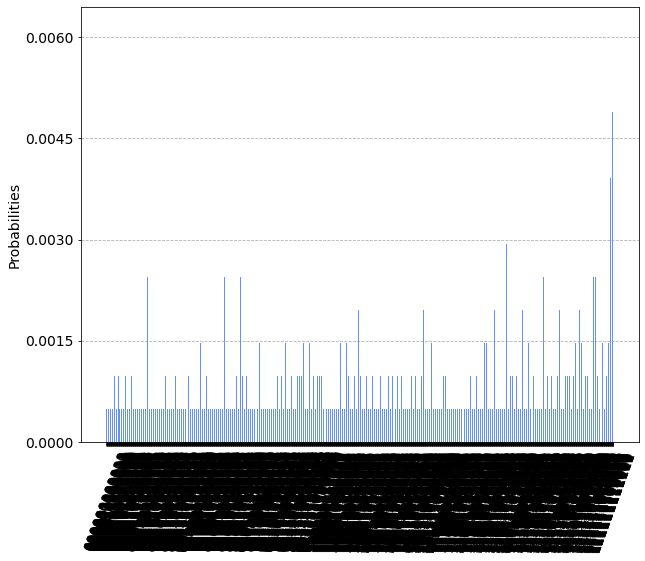

In [12]:
exp_results = job_exp.result()
plot_histogram(exp_results.get_counts(),figsize = (10,8),bar_labels = False)


 --- EXPERIMENTAL RESULTS ---

The sampled mean value is M1_sampled = 12.80 while the true value is M1 = 25.43 

The approximate solution is x* = 010011110110 with C(x*) = 21 

The cost function is distributed as: 



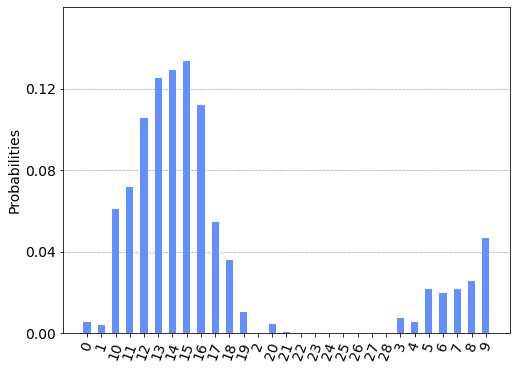

In [13]:
# Evaluate the data from the experiment
counts = exp_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- EXPERIMENTAL RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

### Result of the experiment by ibmq_16_melbourne
It resulted the same value with qasm_simulator, {010011110110} and the optimized value is 21